In [1]:
%run ./model_end_events_for_outages_METHODS.ipynb

In [2]:
from importlib import reload
#reload(Utilities)
#reload(clm)
# NOTE: To reload a class imported as, e.g., 
# from module import class
# One must call:
#   1. import module
#   2. reload module
#   3. from module import class

import sys, os
import re
import string
from pathlib import Path
import json
import pickle

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_datetime64_dtype, is_timedelta64_dtype
from scipy import stats
import datetime
import time
from natsort import natsorted, ns, natsort_keygen
from packaging import version
import copy
from functools import reduce

import itertools

import pyodbc
#---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib import dates
import matplotlib.colors as mcolors
import matplotlib.cm as cm #e.g. for cmap=cm.jet
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#-----
from MeterPremise import MeterPremise
from EEMSP import EEMSP
#-----
from AMI_SQL import AMI_SQL
from AMINonVee_SQL import AMINonVee_SQL
from AMIEndEvents_SQL import AMIEndEvents_SQL
from AMIUsgInst_SQL import AMIUsgInst_SQL
from DOVSOutages_SQL import DOVSOutages_SQL
#-----
from GenAn import GenAn
from AMINonVee import AMINonVee
from AMIEndEvents import AMIEndEvents
from AMIEDE_DEV import AMIEDE_DEV
from MECPODf import MECPODf
from MECPOAn import MECPOAn
from MECPOCollection import MECPOCollection
from AMIUsgInst import AMIUsgInst
from DOVSOutages import DOVSOutages
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_sql_aids_dir())
import Utilities_sql
import TableInfos
from TableInfos import TableInfo
from SQLElement import SQLElement
from SQLElementsCollection import SQLElementsCollection
from SQLSelect import SQLSelectElement, SQLSelect
from SQLFrom import SQLFrom
from SQLWhere import SQLWhereElement, SQLWhere
from SQLJoin import SQLJoin, SQLJoinCollection
from SQLGroupBy import SQLGroupByElement, SQLGroupBy
from SQLHaving import SQLHaving
from SQLOrderBy import SQLOrderByElement, SQLOrderBy
from SQLQuery import SQLQuery
from SQLQueryGeneric import SQLQueryGeneric
#---------------------------------------------------------------------
#sys.path.insert(0, os.path.join(os.path.realpath('..'), 'Utilities'))
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
from Utilities_df import DFConstructType
import Utilities_dt
import Plot_General
import Plot_Box_sns
import Plot_Hist
import Plot_Bar
import GrubbsTest
import DataFrameSubsetSlicer
from DataFrameSubsetSlicer import DataFrameSubsetSlicer as DFSlicer
from CustomJSON import CustomEncoder, CustomWriter

In [3]:
from sklearn.preprocessing import OrdinalEncoder

In [4]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras

import scipy

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# ---------------------------------------------------------------------------------------------------

In [5]:
fig_num=0

# save_dir_model_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230615\Models_00_05'
save_dir_model_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230615\Models'

In [6]:
save_results = False
save_dir_model = None
if save_dir_model is None:
    save_dir_model = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir_model = os.path.join(save_dir_model_base, save_dir_model)
#-----
if not os.path.exists(save_dir_model) and save_results:
    os.makedirs(save_dir_model)

In [7]:
combine_others=True

merged_df_full=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_full.pkl'))
merged_df_no_outg=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg.pkl'))
merged_df_no_outg_prstn=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg_prstn.pkl'))
#-------------------------
# with open(os.path.join(save_dir_model_base, 'mecpo_coll_full.pkl'), 'rb') as handle:
#     mecpo_coll_full = pickle.load(handle)
# with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg.pkl'), 'rb') as handle:
#     mecpo_coll_no_outg = pickle.load(handle)
# with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg_prstn.pkl'), 'rb') as handle:
#     mecpo_coll_no_outg_prstn = pickle.load(handle)
#-------------------------
with open(os.path.join(save_dir_model_base, 'counts_series_full.pkl'), 'rb') as handle:
    counts_series_full = pickle.load(handle)
with open(os.path.join(save_dir_model_base, 'counts_series_no_outg.pkl'), 'rb') as handle:
    counts_series_no_outg = pickle.load(handle)
with open(os.path.join(save_dir_model_base, 'counts_series_no_outg_prstn.pkl'), 'rb') as handle:
    counts_series_no_outg_prstn = pickle.load(handle)
    
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
merged_df_no_outg_prstn.index.names     = ['trsf_pole_nb', 'no_outg_rec_nb']
counts_series_no_outg_prstn.index.names = ['trsf_pole_nb', 'no_outg_rec_nb']

In [8]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(290457, 180)
(599500, 180)
(178946, 180)


### Initiate summary_dict

In [9]:
summary_dict = dict()
#-------------------------
an_keys = natsorted(merged_df_full.columns.get_level_values(0).unique().tolist())
assert(an_keys==natsorted(merged_df_no_outg.columns.get_level_values(0).unique().tolist()))
assert(an_keys==natsorted(merged_df_no_outg_prstn.columns.get_level_values(0).unique().tolist()))
#-----
summary_dict['an_keys'] = an_keys
#-------------------------
# n_top_reasons_to_inclue = 10
n_top_reasons_to_inclue = None
#-----
summary_dict['n_top_reasons_to_inclue'] = n_top_reasons_to_inclue

# !!!!!!! No outage data have indices backwards from outages!!!!!


In [10]:
merged_df_no_outg = merged_df_no_outg.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
counts_series_no_outg = counts_series_no_outg.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb']).squeeze()
#-----
merged_df_no_outg_prstn = merged_df_no_outg_prstn.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
counts_series_no_outg_prstn = counts_series_no_outg_prstn.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb']).squeeze()

In [11]:
if Path(save_dir_model_base).name=='Models' or Path(save_dir_model_base).name=='Models_00_05':
    is_norm=True
elif Path(save_dir_model_base).name=='Models_raw' or Path(save_dir_model_base).name=='Models_00_05_raw':
    is_norm=False
else:
    assert(0)

if n_top_reasons_to_inclue is not None:
    merged_df_full, [merged_df_no_outg, merged_df_no_outg_prstn] = MECPOCollection.get_top_reasons_subset_from_merged_cpo_df_and_project_from_others(
        merged_cpo_df=merged_df_full,
        other_dfs_w_counts_series=[ 
            [merged_df_no_outg, counts_series_no_outg], 
            [merged_df_no_outg_prstn, counts_series_no_outg_prstn]
        ], 
        how='per_mecpo_an', 
        n_reasons_to_include=n_top_reasons_to_inclue,
        combine_others=combine_others,
        output_combine_others_col='Other Reasons',
        SNs_tags=None, 
        is_norm=is_norm, 
        counts_series=counts_series_full
    )

In [12]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(290457, 180)
(599500, 180)
(178946, 180)


In [13]:
merged_df_full=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_full)
merged_df_no_outg=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_no_outg)
merged_df_no_outg_prstn=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_no_outg_prstn)

In [14]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(290457, 186)
(599500, 186)
(178946, 186)


In [15]:
assert(len(set(merged_df_full.index).difference(set(counts_series_full.index)))==0)
assert(len(set(merged_df_no_outg.index).difference(set(counts_series_no_outg.index)))==0)
assert(len(set(merged_df_no_outg_prstn.index).difference(set(counts_series_no_outg_prstn.index)))==0)

merged_df_full = pd.merge(
    merged_df_full, 
    counts_series_full.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

merged_df_no_outg = pd.merge(
    merged_df_no_outg, 
    counts_series_no_outg.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

merged_df_no_outg_prstn = pd.merge(
    merged_df_no_outg_prstn, 
    counts_series_no_outg_prstn.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

In [16]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(290457, 187)
(599500, 187)
(178946, 187)


In [17]:
print(merged_df_full.shape)
print(merged_df_full.index.get_level_values(0).nunique())
print(merged_df_full.index.get_level_values(1).nunique())

(290457, 187)
20714
129413


In [18]:
merged_df_full

01-06 Days  \
                           Access Point has lost connectivity with FHSS 900 MHz band   
outg_rec_nb trsf_pole_nb                                                               
12580837    1863938736669                                                 0.0          
12580900    40830909D30090                                                0.0          
            40830909D30095                                                0.0          
            40830909D30135                                                0.0          
12580986    39830880B40002                                                0.0          
...                                                                       ...          
13149341    1864316751935                                                 0.0          
            1864477751803                                                 0.0          
            1864504751367                                                 0.0          
            1864635751610                                                 0.0          
13149360    41810795C40091                                                0.0          

                                                                     \
                           Demand Reset Detected end of voltage sag   
outg_rec_nb trsf_pole_nb                                              
12580837    1863938736669           0.0                         0.0   
12580900    40830909D30090          0.0                         0.0   
            40830909D30095          0.0                         0.0   
            40830909D30135          0.0                         0.0   
12580986    39830880B40002          0.0                         0.0   
...                                 ...                         ...   
13149341    1864316751935           0.0                         0.0   
            1864477751803           0.0                         0.0   
            1864504751367           0.0                         0.0   
            1864635751610           0.0                         0.0   
13149360    41810795C40091          0.0                         0.0   

                                                                        \
                           Detected end of voltage swell Device Failed   
outg_rec_nb trsf_pole_nb                                                 
12580837    1863938736669                            0.0           0.0   
12580900    40830909D30090                           0.0           0.0   
            40830909D30095                           0.0           0.0   
            40830909D30135                           0.0           0.0   
12580986    39830880B40002                           0.0           0.0   
...                                                  ...           ...   
13149341    1864316751935                            0.0           0.0   
            1864477751803                            0.0           0.0   
            1864504751367                            0.0           0.0   
            1864635751610                            0.0           0.0   
13149360    41810795C40091                           0.0           0.0   

                                                                             \
                           Device exceeded the max allowable trap threshold   
outg_rec_nb trsf_pole_nb                                                      
12580837    1863938736669                                               0.0   
12580900    40830909D30090                                              0.0   
            40830909D30095                                              0.0   
            40830909D30135                                              0.0   
12580986    39830880B40002                                              0.0   
...                                                                     ...   
13149341    1864316751935                                               0.0   
            1864477

In [19]:
merged_df_no_outg

01-06 Days  \
                              Access Point has lost connectivity with FHSS 900 MHz band   
no_outg_rec_nb trsf_pole_nb                                                               
Hp5Jw14085     1676499440341                                                 0.0          
Hp5Jw14086     1676499440341                                                 0.0          
Hp5Jw14087     1676499440341                                                 0.0          
Hp5Jw14088     1676499440341                                                 0.0          
Hp5Jw14089     1676499440341                                                 0.0          
...                                                                          ...          
Hp5Jw1533307   41850816000148                                                0.0          
Hp5Jw1533308   41850816000148                                                0.0          
Hp5Jw1533317   41850816000168                                                0.0          
Hp5Jw1533318   41850816000168                                                0.0          
Hp5Jw1533320   41850816000168                                                0.0          

                                                                        \
                              Demand Reset Detected end of voltage sag   
no_outg_rec_nb trsf_pole_nb                                              
Hp5Jw14085     1676499440341           0.0                         0.0   
Hp5Jw14086     1676499440341           0.0                         0.0   
Hp5Jw14087     1676499440341           0.0                         0.0   
Hp5Jw14088     1676499440341           0.0                         0.0   
Hp5Jw14089     1676499440341           0.0                         0.0   
...                                    ...                         ...   
Hp5Jw1533307   41850816000148          0.0                         0.0   
Hp5Jw1533308   41850816000148          0.0                         0.0   
Hp5Jw1533317   41850816000168          0.0                         0.0   
Hp5Jw1533318   41850816000168          0.0                         0.0   
Hp5Jw1533320   41850816000168          0.0                         0.0   

                                                                           \
                              Detected end of voltage swell Device Failed   
no_outg_rec_nb trsf_pole_nb                                                 
Hp5Jw14085     1676499440341                            0.0           0.0   
Hp5Jw14086     1676499440341                            0.0           0.0   
Hp5Jw14087     1676499440341                            0.0           0.0   
Hp5Jw14088     1676499440341                            0.0           0.0   
Hp5Jw14089     1676499440341                            0.0           0.0   
...                                                     ...           ...   
Hp5Jw1533307   41850816000148                           0.0           0.0   
Hp5Jw1533308   41850816000148                           0.0           0.0   
Hp5Jw1533317   41850816000168                           0.0           0.0   
Hp5Jw1533318   41850816000168                           0.0           0.0   
Hp5Jw1533320   41850816000168                           0.0           0.0   

                                                                                \
                              Device exceeded the max allowable trap threshold   
no_outg_rec_nb trsf_pole_nb                                                      
Hp5Jw14085     1676499440341                                               0.0   
Hp5Jw14086     1676499440341                                               0.0   
Hp5Jw14087     1676499440341                                               0.0   
Hp5Jw14088     1676499440341                                               0.0   
Hp5Jw14089     1676499440341                                               0.0   
...                           

# NEW ORDER

### !!!!!!! No outage data have indices backwards from outages!!!!!

In [20]:
# # ALREADY DONE ABOVE!!!!!
# merged_df_no_outg = merged_df_no_outg.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
# counts_series_no_outg = counts_series_no_outg.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb']).squeeze()
# #-----
# merged_df_no_outg_prstn = merged_df_no_outg_prstn.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
# counts_series_no_outg_prstn = counts_series_no_outg_prstn.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb']).squeeze()

# Build/grab time_info DFs

In [21]:
build_time_infos_dfs=False

In [22]:
ede_data_dirs_no_outg = [
#     r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\20200101_20201231\EndEvents_NoOutg', 
#     r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\20210101_20211231\EndEvents_NoOutg', 
    r'U:\CloudData\dovs_and_end_events_data\20230512\20220101_20221231\NoOutgs\EndEvents'
]
#-----
ede_data_dirs_no_outg_prstn = [
#     r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230301\20200101_20201231\NoOutgs_Pristine\EndEvents', 
#     r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230301\20210101_20211231\NoOutgs_Pristine\EndEvents', 
    r'U:\CloudData\dovs_and_end_events_data\20230301\20220101_20221231\NoOutgs_Pristine\EndEvents'    
]

In [23]:
if build_time_infos_dfs:
    time_infos_df_outg = build_outg_time_infos_df(
        rcpx_df=merged_df_full.copy(), 
        outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
        dummy_col_levels_prefix='dummy_lvl_',     
    )
    time_infos_df_outg.to_pickle(os.path.join(save_dir_model_base, 'time_infos_df_outg.pkl'))    
    #-----
    no_outg_time_infos_df = build_no_outg_time_infos_df(
        ede_data_dirs_no_outg=ede_data_dirs_no_outg,
        save_path=os.path.join(save_dir_model_base, 'no_outg_time_infos_df.pkl')
    )
    #-----
    no_outg_time_infos_prstn_df = build_no_outg_time_infos_df(
        ede_data_dirs_no_outg=ede_data_dirs_no_outg_prstn,
        save_path=os.path.join(save_dir_model_base, 'no_outg_time_infos_prstn_df.pkl')
    )
else:
    time_infos_df_outg          = pd.read_pickle(os.path.join(save_dir_model_base, 'time_infos_df_outg.pkl'))
    no_outg_time_infos_df       = pd.read_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_df.pkl'))
    no_outg_time_infos_prstn_df = pd.read_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_prstn_df.pkl'))
#-------------------------
if 'is_first_after_outg' in no_outg_time_infos_df.index.names:
    no_outg_time_infos_df = no_outg_time_infos_df.droplevel(level='is_first_after_outg', axis=0)
#-----
if 'is_first_after_outg' in no_outg_time_infos_prstn_df.index.names:
    no_outg_time_infos_prstn_df = no_outg_time_infos_prstn_df.droplevel(level='is_first_after_outg', axis=0)
    
#-------------------------
# NOTE: After new DFs are built and saved (using build_no_outg_time_infos_df), the if statements
#         below will no longer be necessary
# Typically, want index as ['no_outg_rec_nb', 'trsf_pole_nb']
if no_outg_time_infos_df.index.names!=['no_outg_rec_nb', 'trsf_pole_nb']:
    no_outg_time_infos_df = no_outg_time_infos_df.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
#-----
if no_outg_time_infos_prstn_df.index.names!=['no_outg_rec_nb', 'trsf_pole_nb']:
    no_outg_time_infos_prstn_df = no_outg_time_infos_prstn_df.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
     
#-------------------------
# Make sure time info found for all
# For the baseline data, typically the time dfs will have more entries than the data
#   This can result from, e.g., transformers not registering any events, in which case
#     they obviously will not be found in the data, but will be found in the time dfs because
#     those are built through the collection of run SQL queries
assert(len(set(merged_df_full.index).difference(set(time_infos_df_outg.index)))==0)
assert(len(set(merged_df_no_outg.index).difference(set(no_outg_time_infos_df.index)))==0)
assert(len(set(merged_df_no_outg_prstn.index).difference(set(no_outg_time_infos_prstn_df.index)))==0)

# =========================================================
# =========================================================

# EEMSP

In [25]:
merge_eemsp = True
build_eemsp = False
mult_strategy='agg'
#-----
cols_of_interest_eemsp = [
    'LOCATION_NB', 
    'MFGR_NM', 
    'INSTALL_DT', 
    'LAST_TRANS_DESC', 
    'EQTYPE_ID', 
    'COOLANT', 
    'INFO', 
    'KVA_SIZE',
    'PHASE_CNT', 
    'PRIM_VOLTAGE', 
    'PROTECTION', 
    'PRU_NUMBER', 
    'SEC_VOLTAGE', 
    'SPECIAL_CHAR', 
    'TAPS', 
    'XFTYPE'
]
cols_of_interest_eemsp_full = cols_of_interest_eemsp + ['LATEST_STATUS', 'REMOVAL_DT', 'SERIAL_NB']
#-------------------------
summary_dict['merge_eemsp'] = merge_eemsp

### !!!!!!!!!!!!!!!! TODO NEED TO DELETE LINE!!!!! 

In [26]:
if merge_eemsp:
    #----------------------------------------------------------------------------------------------------
    # Grab or build df_eemsp_full
    #--------------------------------------------------
    trsf_pole_nbs = list(set(
        merged_df_full.index.get_level_values(1).unique().tolist()+
        merged_df_no_outg.index.get_level_values(1).unique().tolist()+
        merged_df_no_outg_prstn.index.get_level_values(1).unique().tolist()
    ))
    #-------------------------
    if build_eemsp:
        conn_eemsp = Utilities.get_eemsp_oracle_connection()
        df_eemsp_OG = build_df_eemsp(conn_eemsp, trsf_pole_nbs, batch_size=1000, verbose=True, n_update=10)
        df_eemsp_OG.to_pickle(os.path.join(save_dir_model_base, 'df_eemsp_OG.pkl'))
    else:
        df_eemsp_OG = pd.read_pickle(os.path.join(save_dir_model_base, 'df_eemsp_OG.pkl'))
    #-------------------------
    df_eemsp_full = df_eemsp_OG.copy()
    
    #----------------------------------------------------------------------------------------------------
    # Build time_infos_df
    #--------------------------------------------------
    time_infos_df_no_outg = build_no_outg_time_infos_df_for_eemsp(
        no_outg_time_infos_df=no_outg_time_infos_df
    )
    #-----
    time_infos_df_no_outg_prstn = build_no_outg_time_infos_df_for_eemsp(
        no_outg_time_infos_df=no_outg_time_infos_prstn_df
    )
    #-------------------------
    time_infos_df = build_time_infos_df_for_eemsp(
        time_infos_df_outg=time_infos_df_outg, 
        time_infos_df_no_outg=time_infos_df_no_outg, 
        time_infos_df_no_outg_prstn=time_infos_df_no_outg_prstn
    )
    #-------------------------
    assert(time_infos_df.shape[0]==time_infos_df.reset_index().drop_duplicates().shape[0])
    #-----
    del time_infos_df_outg
    del time_infos_df_no_outg
    del time_infos_df_no_outg_prstn
    
    #----------------------------------------------------------------------------------------------------
    # Run reduce1 (or grab reduced df, depending on build_eemsp), keeping only entries from df_eemsp_full 
    #   active at the correct time periods
    #--------------------------------------------------
    if build_eemsp:
        df_eemsp_full = df_eemsp_full[cols_of_interest_eemsp_full].copy()
        #-----
        df_eemsp_reduce1 = reduce1_eemsp_for_outg_trsf(
            time_infos_df=time_infos_df, 
            df_eemsp=df_eemsp_full, 
            outg_rec_nb_idfr  = 'index_0', 
            trsf_pole_nb_idfr = 'index_1', 
            dt_min_col = 't_min', 
            dt_max_col = 't_max', 

            eemsp_location_nb_col = 'LOCATION_NB', 
            eemsp_install_dt_col  = 'INSTALL_DT', 
            eemsp_removal_dt_col  = 'REMOVAL_DT', 
            return_eemsp_outg_rec_nb_col = 'OUTG_REC_NB_TO_MERGE', 
            verbose=True,
            n_update=1000
        )
        df_eemsp_reduce1.to_pickle(os.path.join(save_dir_model_base, 'df_eemsp_reduce1.pkl'))
    else:
        df_eemsp_reduce1 = pd.read_pickle(os.path.join(save_dir_model_base, 'df_eemsp_reduce1.pkl'))
        
    #----------------------------------------------------------------------------------------------------
    # Run reduce2 (or grab reduced df, depending on build_eemsp and whether or not reduced2 df exists), 
    #   keeping only one entry per outg_rec_nb, location_nb (trsf_pole_nb) group
    #--------------------------------------------------
    if(
        not build_eemsp and 
        os.path.exists(os.path.join(save_dir_model_base, f'df_eemsp_reduce2_{mult_strategy}.pkl'))
    ):
        df_eemsp_reduce2 = pd.read_pickle(os.path.join(save_dir_model_base, f'df_eemsp_reduce2_{mult_strategy}.pkl'))
    else:
        df_eemsp_reduce2 = reduce2_eemsp_for_outg_trsf(
            df_eemsp=df_eemsp_reduce1.copy(), 
            mult_strategy=mult_strategy, 
            outg_rec_nb_col='OUTG_REC_NB_TO_MERGE', 
            location_nb_col='LOCATION_NB', 
            numeric_cols = ['KVA_SIZE'], 
            dt_cols = ['INSTALL_DT', 'REMOVAL_DT'], 
            ignore_cols = ['SERIAL_NB'], 
        )
        df_eemsp_reduce2.to_pickle(os.path.join(save_dir_model_base, f'df_eemsp_reduce2_{mult_strategy}.pkl'))  
    #-------------------------
    # No matter of the mult_strategy used, at this point df_eemsp_reduce2 should only have a single
    #   entry for each outg_rec_nb, location_nb pair
    assert(all(df_eemsp_reduce2[['OUTG_REC_NB_TO_MERGE', 'LOCATION_NB']].value_counts()==1))
    
    #----------------------------------------------------------------------------------------------------
    # Clean up df_eemsp_reduce2 and merge with merged_df_full, merged_df_no_outg, and merged_df_no_outg_prstn
    #--------------------------------------------------
    # Can't simply take df_eemsp_reduce2[cols_of_interest_eemsp] because we need also the new column
    #   OUTG_REC_NB_TO_MERGE (and ant others which may be added in the future)
    cols_to_drop = list(set(cols_of_interest_eemsp_full).difference(set(cols_of_interest_eemsp)))
    cols_to_drop = [x for x in cols_to_drop if x in df_eemsp_reduce2.columns]
    if len(cols_to_drop)>0:
        df_eemsp_reduce2 = df_eemsp_reduce2.drop(columns=cols_to_drop)
    #-------------------------
    assert(df_eemsp_reduce2.shape[0]==df_eemsp_reduce2.groupby(['OUTG_REC_NB_TO_MERGE', 'LOCATION_NB']).ngroups)
    print(f"df_eemsp_reduce2['LOCATION_NB'].nunique() = {df_eemsp_reduce2['LOCATION_NB'].nunique()}")
    print(f"len(trsf_pole_nbs)                        = {len(trsf_pole_nbs)}")
    print(f"Diff                                      = {len(trsf_pole_nbs)-df_eemsp_reduce2['LOCATION_NB'].nunique()}")
    print()
    #-------------------------
    print("\nShapes BEFORE merging")
    print(f"merged_df_full.shape          = {merged_df_full.shape}")
    print(f"merged_df_no_outg.shape       = {merged_df_no_outg.shape}")
    print(f"merged_df_no_outg_prstn.shape = {merged_df_no_outg_prstn.shape}")
    #-------------------------
    merged_df_full = merge_rcpx_with_eemsp(
        df_rcpx=merged_df_full, 
        df_eemsp=df_eemsp_reduce2, 
        outg_rec_nb_idfr_rcpx ='index_0', 
        trsf_pole_nb_idfr_rcpx='index_1', 
        outg_rec_nb_idfr_eemsp='OUTG_REC_NB_TO_MERGE', 
        location_nb_idfr_eemsp='LOCATION_NB', 
        set_index=True
    )
    #-------------------------
    merged_df_no_outg = merge_rcpx_with_eemsp(
        df_rcpx=merged_df_no_outg, 
        df_eemsp=df_eemsp_reduce2, 
        outg_rec_nb_idfr_rcpx ='index_0', 
        trsf_pole_nb_idfr_rcpx='index_1', 
        outg_rec_nb_idfr_eemsp='OUTG_REC_NB_TO_MERGE', 
        location_nb_idfr_eemsp='LOCATION_NB', 
        set_index=True
    )
    #-------------------------
    merged_df_no_outg_prstn = merge_rcpx_with_eemsp(
        df_rcpx=merged_df_no_outg_prstn, 
        df_eemsp=df_eemsp_reduce2, 
        outg_rec_nb_idfr_rcpx ='index_0', 
        trsf_pole_nb_idfr_rcpx='index_1', 
        outg_rec_nb_idfr_eemsp='OUTG_REC_NB_TO_MERGE', 
        location_nb_idfr_eemsp='LOCATION_NB', 
        set_index=True
    )
    #-------------------------
    print("\nShapes AFTER merging")
    print(f"merged_df_full.shape          = {merged_df_full.shape}")
    print(f"merged_df_no_outg.shape       = {merged_df_no_outg.shape}")
    print(f"merged_df_no_outg_prstn.shape = {merged_df_no_outg_prstn.shape}")

df_eemsp_reduce2['LOCATION_NB'].nunique() = 190363
len(trsf_pole_nbs)                        = 194627
Diff                                      = 4264


Shapes BEFORE merging
merged_df_full.shape          = (290457, 187)
merged_df_no_outg.shape       = (599500, 187)
merged_df_no_outg_prstn.shape = (178946, 187)

Shapes AFTER merging
merged_df_full.shape          = (283500, 203)
merged_df_no_outg.shape       = (582811, 203)
merged_df_no_outg_prstn.shape = (174448, 203)


# BEG DEL

In [27]:
assert(0)

AssertionError: 

In [ ]:
df_eemsp_reduce1

In [ ]:
df_eemsp_reduce1[['OUTG_REC_NB_TO_MERGE', 'LOCATION_NB']].value_counts()

In [ ]:
dev_df = df_eemsp_reduce1[
    (df_eemsp_reduce1['OUTG_REC_NB_TO_MERGE']=='12696304') 
    & (df_eemsp_reduce1['LOCATION_NB']=='40810166A30211')
].copy()
dev_df

In [ ]:
dev_df.agg({'EQTYPE_ID':lambda x: natsorted(list(set(x.tolist())))})

In [ ]:
dev_df.agg({'EQTYPE_ID':lambda x: ', '.join(natsorted(list(set(x.astype(str).tolist()))))})

In [ ]:
', '.join([1,2,3])

# END DEL

In [ ]:
assert(0)

Text(0.5, 1.0, '# Xfmrs at Pole Location (Only those with >1)')

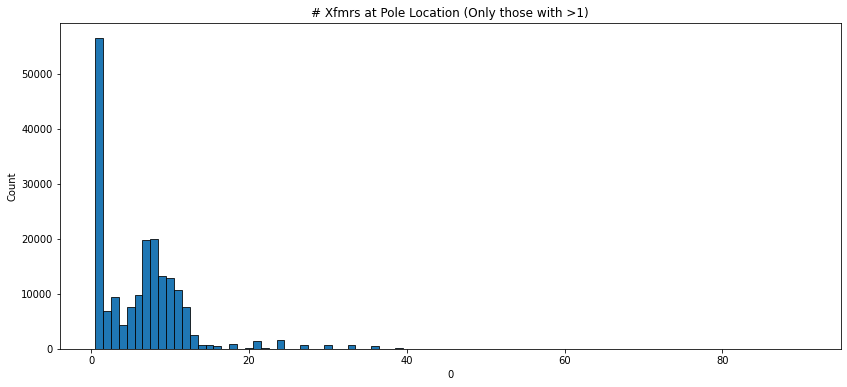

In [28]:
fig,ax = Plot_General.default_subplots()
Plot_Hist.plot_hist(
    ax=ax, 
    df=df_eemsp_reduce1.groupby('LOCATION_NB').size().to_frame(), 
    x_col=0, 
    min_max_and_bin_size=(0,10,1), 
    plot_sns=True, 
    hist_plot_kwargs=dict(discrete=True)
)
ax.set_title('# Xfmrs at Pole Location (Only those with >1)')

Text(0.5, 1.0, '# Xfmrs at Pole Location (Only those with >1)')

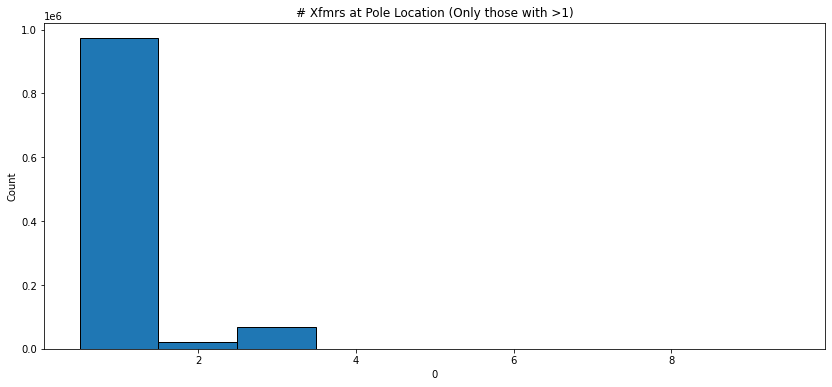

In [29]:
fig,ax = Plot_General.default_subplots()
Plot_Hist.plot_hist(
    ax=ax, 
    df=df_eemsp_reduce1.groupby(['LOCATION_NB', 'OUTG_REC_NB_TO_MERGE']).size().to_frame(), 
    x_col=0, 
    min_max_and_bin_size=(0,10,1), 
    plot_sns=True, 
    hist_plot_kwargs=dict(discrete=True)
)
ax.set_title('# Xfmrs at Pole Location (Only those with >1)')

In [30]:
df_eemsp_reduce2

,OUTG_REC_NB_TO_MERGE,LOCATION_NB,KVA_SIZE,INSTALL_DT,COOLANT,EQTYPE_ID,INFO,LAST_TRANS_DESC,MFGR_NM,PHASE_CNT,PRIM_VOLTAGE,PROTECTION,PRU_NUMBER,SEC_VOLTAGE,SPECIAL_CHAR,TAPS,XFTYPE,n_eemsp
0,12580837,1863938736669,50.0,2009-03-16 08:48:09,Oil,1848.0,2 Pri Bushing,New Install,WESTINGHOUSE,1,13200GRDY/ 7620V,CSP,8360,120/240V,None,Y,Pole Mtg.,1
1,12580900,40830909D30095,25.0,2020-12-02 08:00:24,Oil,1675.0,1 Pri Bushing,Other,COOPER POWER SYSTEMS,1,12470GRDY/7200V,None,8320,120/240V,None,N,Pole Mtg.,1
2,12580900,40830909D30135,50.0,2020-12-02 08:00:21,Oil,1816.0,2 Pri Bushing,New Install,KUHLMAN ELECTRIC,1,7200/12470Y,None,8360,120/240V,None,N,Pole Mtg.,1
3,12580986,39830880B40002,75.0,2007-11-09 14:40:05,Oil,1907.0,2 Pri Bushing,Other,WESTINGHOUSE,1,7200/12470Y,None,8380,120/240V,None,N,Pole Mtg.,1
4,12580993,41820782A20052,25.0,2005-03-30 15:51:19,Oil,1677.0,2 Pri Bushing,Load Increase,CENTRAL MOLONEY,1,7200/12470Y,None,8320,120/240V,None,N,Pole Mtg.,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060955,Hp5Jw999995,40820551A20011,50.0,2017-12-26 20:34:43,Oil,1797.0,2 Pri Bushing,Maintenance Replacement,HOWARD INDUSTRIES,1,2400/4160Y,None,8360,120/240V,None,N,Pole Mtg.,1
1060956,Hp5Jw999996,40820551A20011,50.0,2017-12-26 20:34:43,Oil,1797.0,2 Pri Bushing,Maintenance Replacement,HOWARD INDUSTRIES,1,2400/4160Y,None,8360,120/240V,None,N,Pole Mtg.,1
1060957,Hp5Jw999997,40820551A20014,25.0,2007-02-07 15:58:55,Oil,1656.0,2 Pri Bushing,Other,WESTINGHOUSE,1,2400/4160Y,None,8320,120/240V,None,N,Pole Mtg.,1
1060958,Hp5Jw999998,40820551A20014,25.0,2007-02-07 15:58:55,Oil,1656.0,2 Pri Bushing,Other,WESTINGHOUSE,1,2400/4160Y,None,8320,120/240V,None,N,Pole Mtg.,1


# After new data generated, below should be single line, not 2 rows

In [ ]:
# no_outg_time_infos_df.loc['41820806C20094', 'Hp5Jw1309717']
no_outg_time_infos_df.loc['Hp5Jw1309717', '41820806C20094']

In [ ]:
dev_df = no_outg_time_infos_df.loc['Hp5Jw1309717', '41820806C20094'].copy()
dev_df = dev_df.reset_index()

In [ ]:
dev_df

In [ ]:
# Utilities_df.consolidate_df(
#     df=dev_df, 
#     groupby_cols=['trsf_pole_nb','no_outg_rec_nb','t_min','t_max'], 
#     cols_shared_by_group=None, 
#     cols_to_collect_in_lists=['prem_nbs']
# )

In [ ]:
dev_df.groupby(
    ['trsf_pole_nb','no_outg_rec_nb','t_min','t_max'], 
    as_index=False,
    group_keys=False
)['prem_nbs'].sum()

In [ ]:
no_outg_time_infos_df

In [ ]:
start=time.time()
idk = no_outg_time_infos_df.reset_index().groupby(
    ['trsf_pole_nb','no_outg_rec_nb','t_min','t_max'], 
    as_index=False,
    group_keys=False
)['prem_nbs'].sum()
print(time.time()-start)
idk

In [ ]:
dev_df

In [ ]:
# start=time.time()
# idk = dev_df.groupby(
#     ['trsf_pole_nb','no_outg_rec_nb','t_min','t_max'], 
#     as_index=False,
#     group_keys=False
# )['prem_nbs'].sum()
# print(time.time()-start)
# idk

start=time.time()
idk = no_outg_time_infos_df.reset_index().groupby(
    ['trsf_pole_nb','no_outg_rec_nb','t_min','t_max'], 
    as_index=False,
    group_keys=False
)['prem_nbs'].sum()
print(time.time()-start)
idk

In [ ]:
# start=time.time()
# idkb = dev_df.groupby(
#     ['trsf_pole_nb','no_outg_rec_nb','t_min','t_max'], 
#     as_index=True,
#     group_keys=False
# ).apply(lambda x: x['prem_nbs'].sum()).reset_index()
# print(time.time()-start)
# idkb

start=time.time()
idkb = no_outg_time_infos_df.reset_index().groupby(
    ['trsf_pole_nb','no_outg_rec_nb','t_min','t_max'], 
    as_index=True,
    group_keys=False
).apply(lambda x: x['prem_nbs'].sum()).reset_index()
print(time.time()-start)
idkb

In [ ]:
reload(Utilities_df)

In [ ]:
fuckr = Utilities_df.consolidate_df(
    df=dev_df, 
    groupby_cols=['trsf_pole_nb', 'no_outg_rec_nb', 't_min', 't_max'], 
    cols_shared_by_group=None, 
    cols_to_collect_in_lists=['prem_nbs'], 
    custom_aggs_for_list_cols=lambda x: list(set(itertools.chain(*x)))
)

In [ ]:
fuckr

In [ ]:
start=time.time()
idk3 = Utilities_df.consolidate_df(
    df=no_outg_time_infos_df.reset_index(), 
    groupby_cols=['trsf_pole_nb', 'no_outg_rec_nb', 't_min', 't_max'], 
    cols_shared_by_group=None, 
    cols_to_collect_in_lists=['prem_nbs'], 
    custom_aggs_for_list_cols=lambda x: list(set(itertools.chain(*x)))
)
print(time.time()-start)

In [ ]:
start=time.time()
idk4 = Utilities_df.consolidate_df(
    df=no_outg_time_infos_df.reset_index(), 
    groupby_cols=['trsf_pole_nb', 'no_outg_rec_nb', 't_min', 't_max'], 
    cols_shared_by_group=None, 
    cols_to_collect_in_lists=['prem_nbs'], 
    custom_aggs_for_list_cols=lambda x: natsorted(list(set(itertools.chain(*x))))
)
print(time.time()-start)

In [ ]:
print(idk3.shape[0])
print(idk4.shape[0])

In [ ]:
any(idk3.reset_index()[['trsf_pole_nb', 'no_outg_rec_nb', 't_min', 't_max']].value_counts()>1)

In [ ]:
dev_df.groupby(['trsf_pole_nb', 'no_outg_rec_nb', 't_min', 't_max'], dropna=True)[['prem_nbs']].agg(sum)

In [ ]:
dev_df

In [ ]:
list(itertools.chain(*list2d))

In [ ]:
dev_df.groupby(['trsf_pole_nb', 'no_outg_rec_nb', 't_min', 't_max'], dropna=True)[['prem_nbs']].agg(lambda x: list(itertools.chain(*x)))

In [ ]:
dev_df

In [ ]:
idk[idk['trsf_pole_nb']=='1728638509749']

In [ ]:
no_outg_time_infos_df.loc['1615473439541']

In [ ]:
# start=time.time()
# idk2 = dev_df.groupby(
#     ['trsf_pole_nb','no_outg_rec_nb','t_min','t_max'], 
#     as_index=True,
#     group_keys=False
# ).apply(
#     lambda x: Utilities_df.consolidate_column_of_lists(
#         df=x, 
#         col='prem_nbs', 
#         sort=False
#     )
# ).reset_index()
# print(time.time()-start)
# idk2

start=time.time()
idk2 = no_outg_time_infos_df.reset_index().groupby(
    ['trsf_pole_nb','no_outg_rec_nb','t_min','t_max'], 
    as_index=True,
    group_keys=False
).apply(
    lambda x: Utilities_df.consolidate_column_of_lists(
        df=x, 
        col='prem_nbs', 
        sort=False
    )
).reset_index()
print(time.time()-start)
idk2

In [ ]:
idk.equals(idkb)

In [ ]:
idk2.equals(idkb)

In [ ]:
idk.iloc[:, :-1].equals(idkb.iloc[:, :-1])

In [ ]:
idk.iloc[:, :-1].equals(idk2.iloc[:, :-1])

In [ ]:
start=time.time()
we1 = idk['prem_nbs'].apply(lambda x: natsorted(set(x)))
print(time.time()-start)
we1

In [ ]:
start=time.time()
we2 = idk['prem_nbs'].apply(lambda x: x if len(x)==1 else natsorted(set(x)))
print(time.time()-start)
we2

In [ ]:
summary_paths = [
    r'U:\CloudData\dovs_and_end_events_data\20230512\20220101_20221231\NoOutgs\EndEvents\summary_files\end_events_5305_summary.json', 
    r'U:\CloudData\dovs_and_end_events_data\20230512\20220101_20221231\NoOutgs\EndEvents\summary_files\end_events_5306_summary.json'
]

In [ ]:
import AMIEDE_DEV
reload(AMIEDE_DEV)
from AMIEDE_DEV import AMIEDE_DEV

In [ ]:
fml1 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_from_summary_files_OLD2(summary_paths)
fml1.sort_index()

In [ ]:
fml2 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_from_summary_files(summary_paths)
fml2.sort_index()

In [ ]:
fml1.shape

In [ ]:
fml2.shape

In [ ]:
fml1.loc['41820806C20094', 'Hp5Jw1309717']['prem_nbs'].tolist()

In [ ]:
fml2.loc['41820806C20094', 'Hp5Jw1309717']['prem_nbs'].tolist()

In [ ]:
start=time.time()
idk = no_outg_time_infos_df.reset_index().groupby(
    ['trsf_pole_nb','no_outg_rec_nb','t_min','t_max'], 
    as_index=False,
    group_keys=False
)['prem_nbs'].sum()
idk['prem_nbs']=idk['prem_nbs'].apply(lambda x: list(set(x)))
print(time.time()-start)
idk

In [ ]:
idk['prem_nbs']  = idk['prem_nbs'].apply(lambda x: natsorted(x))
idk3['prem_nbs'] = idk3['prem_nbs'].apply(lambda x: natsorted(x))

In [ ]:
idk.equals(idk3.reset_index())

In [ ]:
    #@staticmethod
    def get_no_outg_time_interval_infos_df_from_summary_files_NEW(
        summary_paths, 
        output_prem_nbs_col='prem_nbs', 
        output_t_min_col='t_min', 
        output_t_max_col='t_max', 
        make_addtnl_groupby_idx=True, 
        include_summary_paths=False
    ):
        r"""
        Handles multiple summary files

        Note: drop_duplicates will remove rows if indices are different (but all columns equal)
              Therefore, if make_addtnl_groupby_idx==True, this should only be done AFTER drop duplicates
              This explains why make_addtnl_groupby_idx=False in the call to AMIEDE_DEV.get_no_outg_time_interval_infos_df_from_summary_file
        Note: The reason for drop duplicates if for the case where a collection is split over mulitple
              files/runs (i.e., the asynchronous case)
        """
        return_df = pd.DataFrame()
        for summary_path in summary_paths:
            df_i = AMIEDE_DEV.get_no_outg_time_interval_infos_df_from_summary_file(
                summary_path=summary_path, 
                output_prem_nbs_col=output_prem_nbs_col, 
                output_t_min_col=output_t_min_col, 
                output_t_max_col=output_t_max_col, 
                make_addtnl_groupby_idx=False, 
                include_summary_path=include_summary_paths
            )
            return_df = pd.concat([return_df, df_i], ignore_index=True)
        #-------------------------
        # It is possible that a group was split over multiple files/runs
        #   e.g., if not run using slim, then a particular outage/transformer group might have premises split
        #     across neighboring files
        # The method below will combine such entries
        # NOTE: Could use Utilities_df.consolidate_df with groupby_cols containing all columns except output_prem_nbs_col
        #         and 'summary_path' and custom_aggs_for_list_cols={output_prem_nbs_col : lambda x: list(set(itertools.chain(*x)))}
        #       However, in testing, found the below method to be much faster, BUT the 'summary_path' column, if it was included
        #         must be omitted
        groupby_cols = [x for x in return_df.columns if x not in [output_prem_nbs_col, 'summary_path']]
        return_df = return_df.groupby(groupby_cols, as_index=False, group_keys=False)[output_prem_nbs_col].sum()
        return_df[output_prem_nbs_col] = return_df[output_prem_nbs_col].apply(lambda x: list(set(x)))
        #-------------------------
        if make_addtnl_groupby_idx:
            addtnl_groupby_cols = [x for x in return_df.columns 
                                   if x not in [output_prem_nbs_col, output_t_min_col, output_t_max_col, 'summary_path']]
            return_df=return_df.set_index(addtnl_groupby_cols)
        return return_df

In [ ]:
summary_paths = [
    r'U:\CloudData\dovs_and_end_events_data\20230512\20220101_20221231\NoOutgs\EndEvents\summary_files\end_events_{}_summary.json'.format(i) 
    for i in range(1000)
]


In [ ]:
start=time.time()
fml1 = AMIEDE_DEV.get_no_outg_time_interval_infos_df_from_summary_files(summary_paths)
fml1.sort_index()
print(time.time()-start)

In [ ]:
start=time.time()
fml2 = get_no_outg_time_interval_infos_df_from_summary_files_NEW(summary_paths)
fml2.sort_index()
print(time.time()-start)

In [ ]:
fml1.equals(fml2)

# SEEMS NEW METHOD ISN'T MUCH FASTER!

In [ ]:
start=time.time()
idk = no_outg_time_infos_df.reset_index().groupby(
    ['trsf_pole_nb','no_outg_rec_nb','t_min','t_max'], 
    as_index=False,
    group_keys=False
)['prem_nbs'].sum()
idk['prem_nbs']=idk['prem_nbs'].apply(lambda x: list(set(x)))
print(time.time()-start)
idk

In [ ]:
idk

In [ ]:
idk3